In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import set_figure_defaults
from src.analysis import get_probability, get_is_classified
from src.parameters import (
    ANIMALS,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    _BRAIN_AREAS,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
    continuous_transition_types,
)


from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)

set_figure_defaults()

In [3]:
epoch_key = "bon", 4, 2
ripple_number = 106

In [4]:
animal, day, epoch = epoch_key

In [5]:
from src.load_data import load_data

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO04.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [6]:
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_spikes_dataframe,
    make_neuron_dataframe,
)

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = neuron_info.loc[
    (neuron_info.numspikes > 100)
    & neuron_info.area.isin(_BRAIN_AREAS)
    & (neuron_info.type == "principal")
]

In [7]:
spike_times = [
    get_spikes_dataframe(neuron_key, ANIMALS) for neuron_key in neuron_info.index
]

In [8]:
multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]

In [9]:
position_1D = data["position_info"].loc[:, "linear_position"]
position_2D = data["position_info"].loc[:, ["x_position", "y_position"]]
is_training = data["position_info"].speed > 4
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

ripple_start, ripple_end = (
    data["ripple_times"].loc[ripple_number].start_time,
    data["ripple_times"].loc[ripple_number].end_time,
)

ripple_position_info = data["position_info"].loc[ripple_start:ripple_end]

In [10]:
data.keys()

dict_keys(['position_info', 'ripple_times', 'spikes', 'multiunit', 'lfps', 'tetrode_info', 'ripple_filtered_lfps', 'ripple_lfps', 'multiunit_firing_rate', 'sampling_frequency'])

In [11]:
posterior_time_cmap = "viridis_r"

### 2D Clusterless Classifier

In [12]:
clusterless_classifier_2D = ClusterlessClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model,
    model_kwargs=model_kwargs,
).fit(position_2D, data["multiunit"], is_training=is_training)

In [13]:
time_slice = slice(*data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]])
m = data["multiunit"].sel(time=time_slice)

clusterless_results_2D = clusterless_classifier_2D.predict(m, m.time - m.time[0])

In [14]:
clusterless_results_2D = clusterless_results_2D.assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

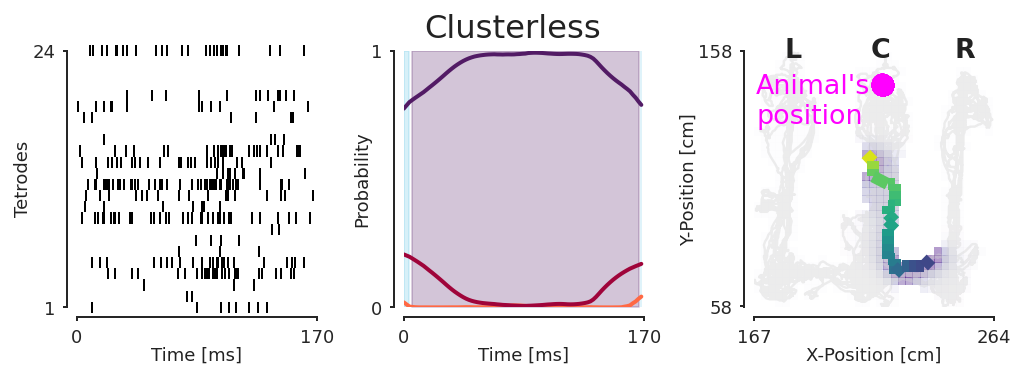

In [15]:
from src.figure2_supplemental1 import plot_2D_results

plot_2D_results(
    multiunit_times,
    data,
    clusterless_results_2D,
    clusterless_classifier_2D,
    epoch_key,
    ripple_number,
    posterior_time_cmap=posterior_time_cmap,
    data_type="clusterless",
)

### 2D Sorted Spikes Classifier

In [16]:
from dask.distributed import Client

client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:46493 Dashboard: http://127.0.0.1:34517/status,Cluster Workers: 16 Cores: 64 Memory: 1.62 TB


In [17]:
sorted_spikes_classifier_1D = SortedSpikesClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=spike_model_penalty,
    knot_spacing=knot_spacing,
    continuous_transition_types=continuous_transition_types,
)
sorted_spikes_classifier_1D.fit(
    position_1D,
    data["spikes"],
    is_training=is_training,
    track_graph=track_graph,
    center_well_id=center_well_id,
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
)

SortedSpikesClassifier(discrete_transition_diag=0.98, knot_spacing=5,
                       movement_var=6.0, place_bin_size=3.0, replay_speed=1,
                       spike_model_penalty=0.5)

In [18]:
from src.analysis import get_place_field_max

place_field_max = get_place_field_max(sorted_spikes_classifier_1D)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

ordered_spike_times = [spike_times[i] for i in linear_position_order]

In [19]:
sorted_spikes_classifier_2D = SortedSpikesClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
).fit(position_2D, data["spikes"], is_training=is_training)

In [20]:
time_slice = slice(ripple_start, ripple_end)
s = data["spikes"].loc[time_slice]
sorted_spikes_results_2D = sorted_spikes_classifier_2D.predict(
    s, time=s.index - s.index[0]
).assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY))

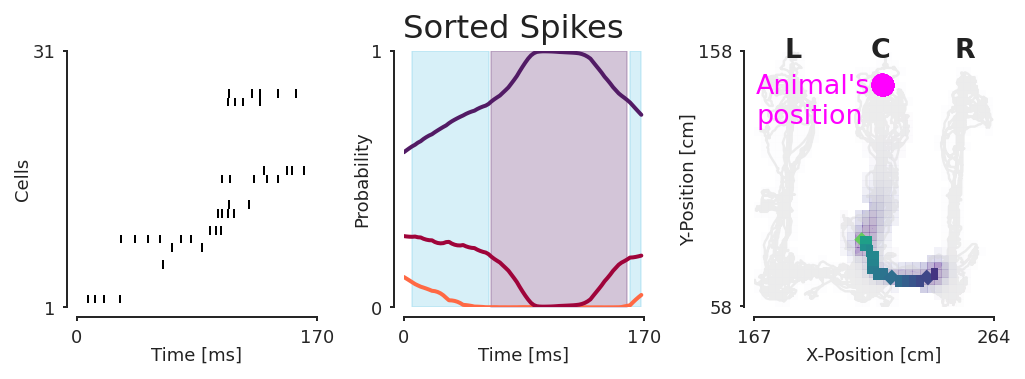

In [21]:
from src.figure2_supplemental1 import plot_2D_results

cbar = plot_2D_results(
    ordered_spike_times,
    data,
    sorted_spikes_results_2D,
    sorted_spikes_classifier_2D,
    epoch_key,
    ripple_number,
    posterior_time_cmap=posterior_time_cmap,
    data_type="sorted_spikes",
)

In [22]:
client.close()